# How to prepare the data

We use a simplified version of the data set constructed in Chapter 4, Alpha factor research. It consists of daily stock prices provided by Quandl for the 2010-2017 period and various engineered features. 

The decision tree models in this chapter are not equipped to handle missing or categorical variables, so we will apply dummy encoding to the latter after dropping any of the former.

In [1]:
%matplotlib inline

import warnings
import os
from pathlib import Path
import numpy as np
import pandas as pd
from pandas_datareader import data as pdr
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz, _tree
from sklearn.linear_model import LinearRegression, Ridge, LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve, mean_squared_error, precision_recall_curve
from sklearn.impute import SimpleImputer
import statsmodels.api as sm
from scipy.interpolate import interp1d, interp2d

C:\Users\Elid-PC.DESKTOP-MG9DS93\anaconda3\lib\site-packages\pandas_datareader\compat\__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [2]:
warnings.filterwarnings('ignore')
plt.style.use('ggplot')

## Get Data

In [3]:
end_date = '2020-04-19'
start_date = '2017-04-20'
prices = pd.DataFrame(pdr.DataReader( 'AAPL','yahoo', start_date, end_date))
# DJIA
for ticker in ['AAPL','AXP','BA','CAT','CSCO','CVX','DIS','GS','HD','IBM',
               'INTC','JNJ','JPM','KO','MCD','MMM','MRK','MSFT','NKE',
               'PFE','PG','TRV','UNH','V','VZ','WBA','WMT','XOM']:
    #Downloads data from Yahoo
    prices[ticker] = pdr.DataReader( ticker,'yahoo', start_date, end_date)['Adj Close'].values
    
prices.drop(['High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close'], axis = 1, inplace = True)   
prices.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 755 entries, 2017-04-19 to 2020-04-17
Data columns (total 28 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AAPL    755 non-null    float64
 1   AXP     755 non-null    float64
 2   BA      755 non-null    float64
 3   CAT     755 non-null    float64
 4   CSCO    755 non-null    float64
 5   CVX     755 non-null    float64
 6   DIS     755 non-null    float64
 7   GS      755 non-null    float64
 8   HD      755 non-null    float64
 9   IBM     755 non-null    float64
 10  INTC    755 non-null    float64
 11  JNJ     755 non-null    float64
 12  JPM     755 non-null    float64
 13  KO      755 non-null    float64
 14  MCD     755 non-null    float64
 15  MMM     755 non-null    float64
 16  MRK     755 non-null    float64
 17  MSFT    755 non-null    float64
 18  NKE     755 non-null    float64
 19  PFE     755 non-null    float64
 20  PG      755 non-null    float64
 21  TRV     755 non-null

### Create monthly return series

Remove outliers

In [4]:
returns = []
returns = prices.resample('D').last().pct_change().stack().swaplevel()
returns = (returns[returns.between(left=returns.quantile(.05), 
                                   right=returns.quantile(.95))].to_frame('returns'))
returns.rename_axis(['ticker','date'])
returns.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 27568 entries, ('AAPL', Timestamp('2017-04-20 00:00:00', freq='D')) to ('WMT', Timestamp('2020-04-17 00:00:00', freq='D'))
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   returns  27568 non-null  float64
dtypes: float64(1)
memory usage: 305.0+ KB


In [5]:
for t in [5,20]:
    returns[f't-{t}'] = returns.returns.shift(t)
returns = returns.dropna()
returns.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 27548 entries, ('UNH', Timestamp('2017-04-20 00:00:00', freq='D')) to ('WMT', Timestamp('2020-04-17 00:00:00', freq='D'))
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   returns  27548 non-null  float64
 1   t-5      27548 non-null  float64
 2   t-20     27548 non-null  float64
dtypes: float64(3)
memory usage: 735.2+ KB


In [6]:
returns

,,returns,t-5,t-20
,Date,,,
UNH,2017-04-20,0.013530,0.007073,0.012511
V,2017-04-20,0.015599,0.009667,0.005045
VZ,2017-04-20,-0.010830,0.003868,0.005513
WBA,2017-04-20,0.007544,-0.003013,0.006236
WMT,2017-04-20,0.009856,-0.012625,0.009320
...,...,...,...,...
MMM,2020-04-17,0.010766,0.012823,-0.001860
MRK,2020-04-17,0.005542,-0.004834,0.007946
MSFT,2020-04-17,0.008812,-0.013569,0.015153


### Time Period Dummies

In [7]:
# returns = returns.reset_index('date')
dates = returns.index.get_level_values('Date')

In [8]:
returns

,,returns,t-5,t-20
,Date,,,
UNH,2017-04-20,0.013530,0.007073,0.012511
V,2017-04-20,0.015599,0.009667,0.005045
VZ,2017-04-20,-0.010830,0.003868,0.005513
WBA,2017-04-20,0.007544,-0.003013,0.006236
WMT,2017-04-20,0.009856,-0.012625,0.009320
...,...,...,...,...
MMM,2020-04-17,0.010766,0.012823,-0.001860
MRK,2020-04-17,0.005542,-0.004834,0.007946
MSFT,2020-04-17,0.008812,-0.013569,0.015153


In [9]:
returns.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 27548 entries, ('UNH', Timestamp('2017-04-20 00:00:00', freq='D')) to ('WMT', Timestamp('2020-04-17 00:00:00', freq='D'))
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   returns  27548 non-null  float64
 1   t-5      27548 non-null  float64
 2   t-20     27548 non-null  float64
dtypes: float64(3)
memory usage: 735.2+ KB


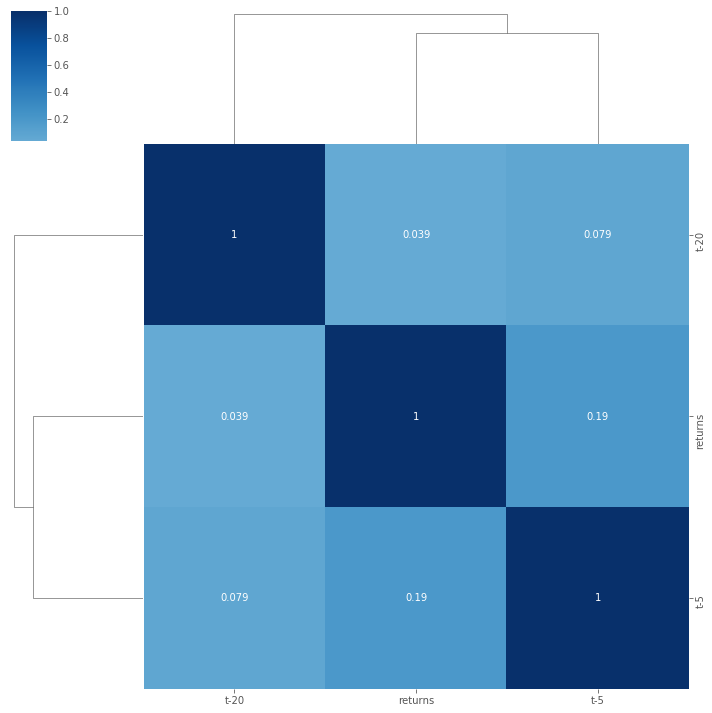

In [10]:
# cmap = sns.diverging_palette(10, 220, as_cmap=True)
sns.clustermap(returns.corr('spearman'), annot=True, center=0, cmap='Blues');

### Store data

In [11]:
returns.dropna()
returns.to_csv('Feature_Engineering.csv')